\newpage

## Question 1
The goal of this project is to classify the CKD patients based on the predictor variable about health information. Based on the individual's health information, the patient will be classified into CKD or not CKD.

In [2760]:
# impoart libraries and dataset
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.cm as cm

df = pd.read_csv("https://archive.ics.uci.edu/static/public/336/data.csv")

## Question 2

In [2761]:
# analyze the data types of each variables
print(df.dtypes)

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object


The data types of variables: `sg`,`al`,`su`,`rbc`,`pc`,`pcc`,`ba`,`htn`,`dm`,`cad`,`appet`,`pe`,`ane`, and `class` are nominal based on the dataset library, so dummy variables are required.

In [2762]:
# list of categorical variables
cat_col=['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane','class']

# list of numerical variables
num_col=df.drop(cat_col, axis=1).columns

# levels of each categorical variables
for col in cat_col:
    print(df[col].unique())


[1.02  1.01  1.005 1.015   nan 1.025]
[ 1.  4.  2.  3.  0. nan  5.]
[ 0.  3.  4.  1. nan  2.  5.]
[nan 'normal' 'abnormal']
['normal' 'abnormal' nan]
['notpresent' 'present' nan]
['notpresent' 'present' nan]
['yes' 'no' nan]
['yes' 'no' '\tno' nan]
['no' 'yes' nan]
['good' 'poor' nan]
['no' 'yes' nan]
['no' 'yes' nan]
['ckd' 'ckd\t' 'notckd']


Looking at the categorical variables,`dm` and `class`, there are new levels that are not listed in the dataset library in categorical variables. It indicates the 'tab' and this is most likely a typo, so need to be adjusted.

In [2763]:
# justification for `dm` and `class` variables
df['class'] = df['class'].str.replace('ckd\t', 'ckd')
df['dm'] = df['dm'].str.replace('\tno', 'no')

# convert to data type category
for col in cat_col:
    df[col]=pd.Categorical(df[col])

df.dtypes

age       float64
bp        float64
sg       category
al       category
su       category
rbc      category
pc       category
pcc      category
ba       category
bgr       float64
bu        float64
sc        float64
sod       float64
pot       float64
hemo      float64
pcv       float64
wbcc      float64
rbcc      float64
htn      category
dm       category
cad      category
appet    category
pe       category
ane      category
class    category
dtype: object

All the variables are not converted and have the same data type as indicated in the dataset library.

## Question 3

(400, 25)
              age          bp         bgr          bu          sc         sod  \
count  391.000000  388.000000  356.000000  381.000000  383.000000  313.000000   
mean    51.483376   76.469072  148.036517   57.425722    3.072454  137.528754   
std     17.169714   13.683637   79.281714   50.503006    5.741126   10.408752   
min      2.000000   50.000000   22.000000    1.500000    0.400000    4.500000   
25%     42.000000   70.000000   99.000000   27.000000    0.900000  135.000000   
50%     55.000000   80.000000  121.000000   42.000000    1.300000  138.000000   
75%     64.500000   80.000000  163.000000   66.000000    2.800000  142.000000   
max     90.000000  180.000000  490.000000  391.000000   76.000000  163.000000   

              pot        hemo         pcv          wbcc        rbcc  
count  312.000000  348.000000  329.000000    294.000000  269.000000  
mean     4.627244   12.526437   38.884498   8406.122449    4.707435  
std      3.193904    2.912587    8.990105   2944.4

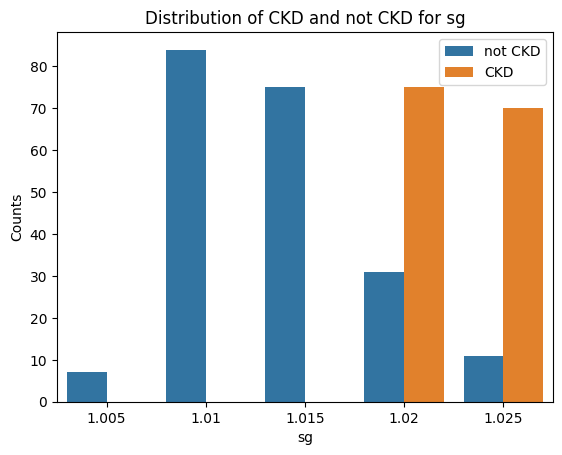

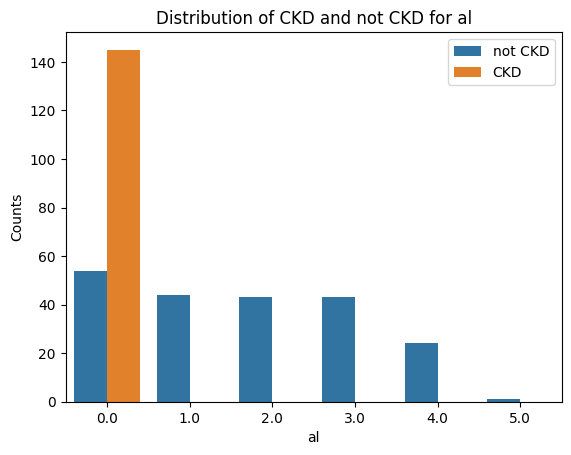

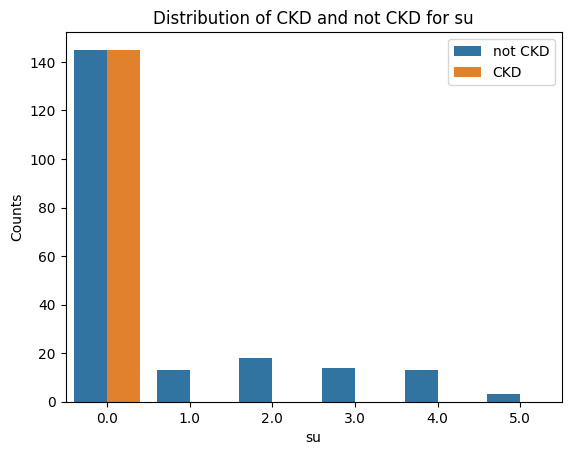

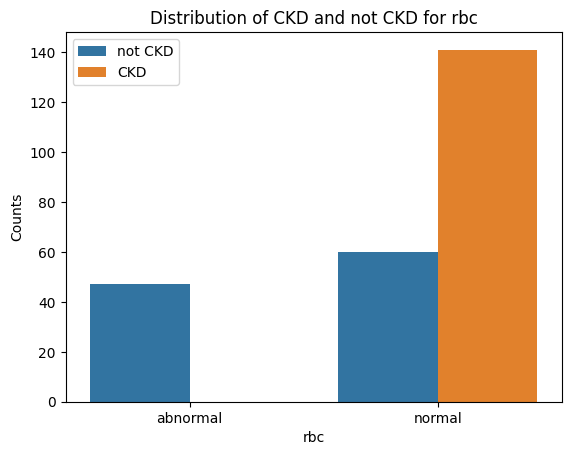

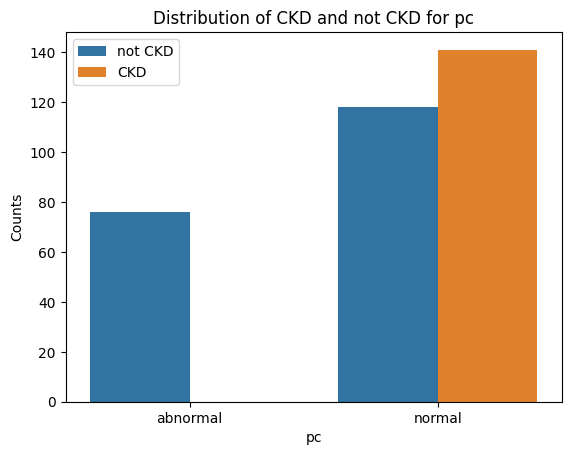

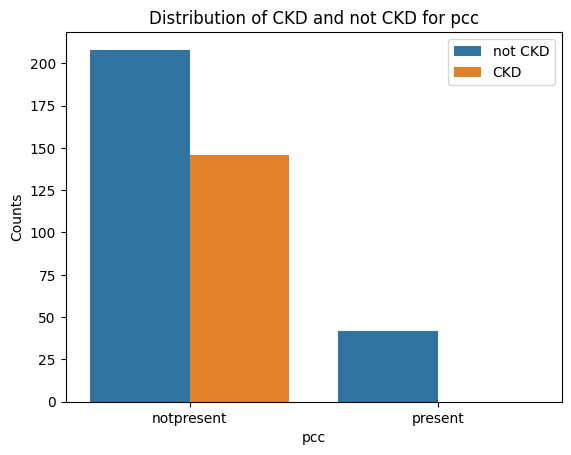

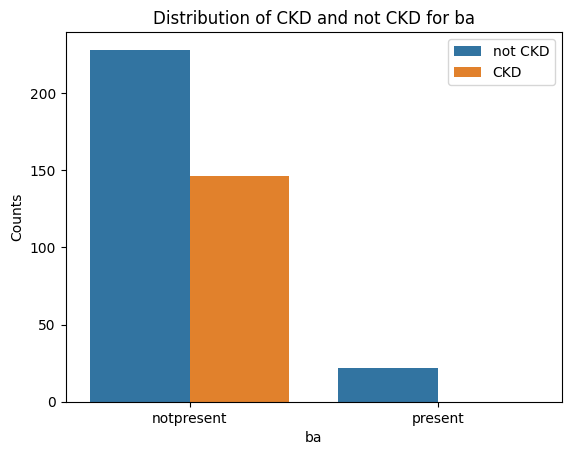

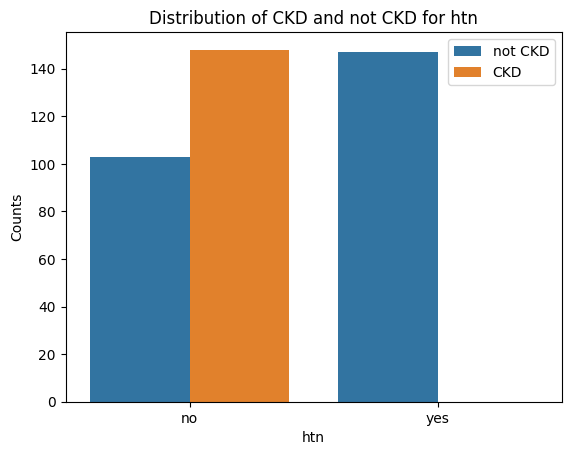

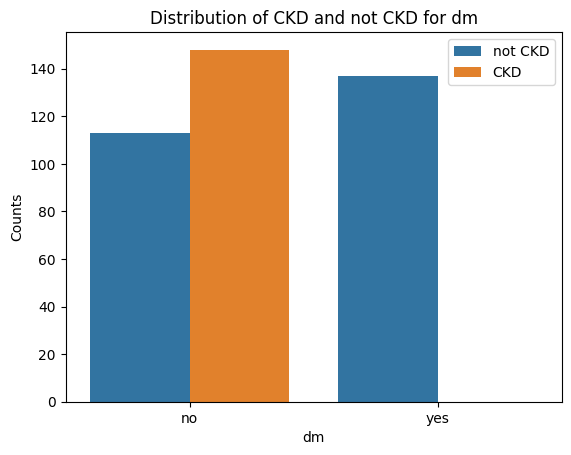

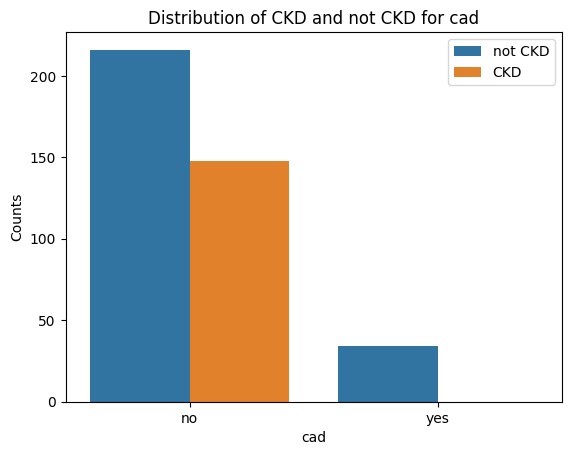

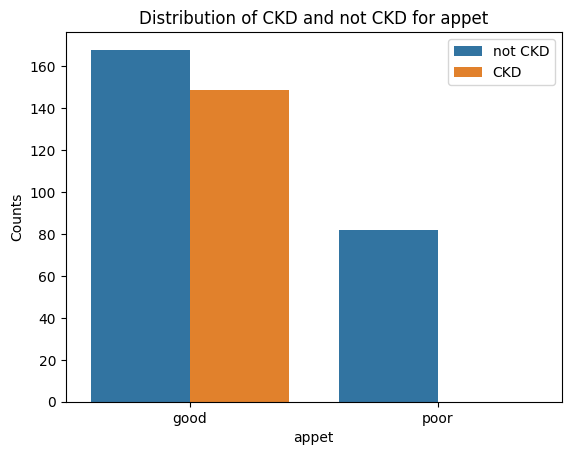

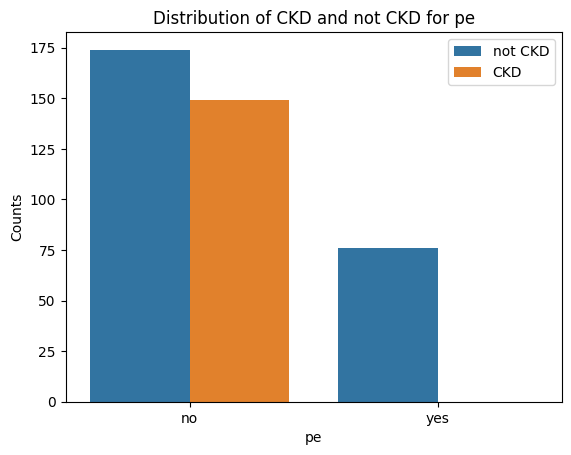

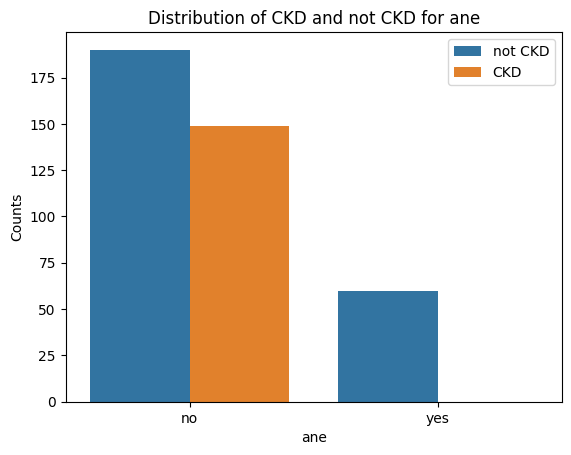

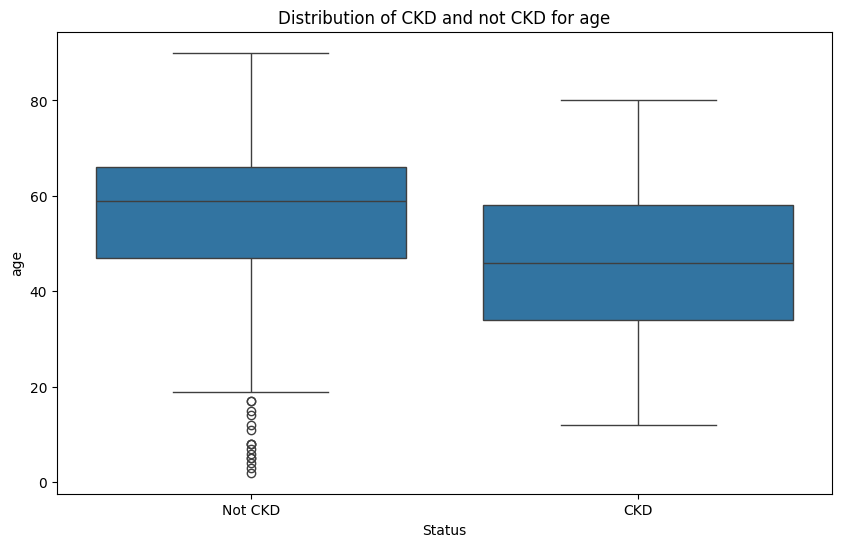

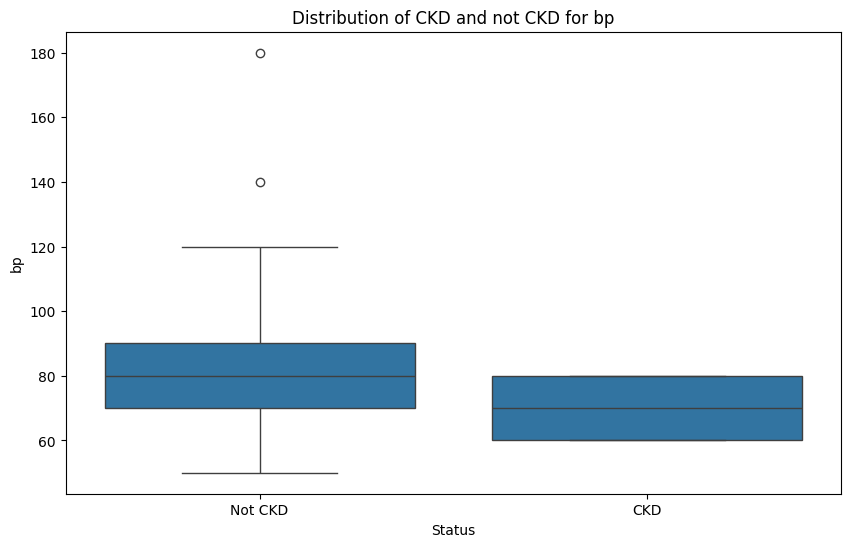

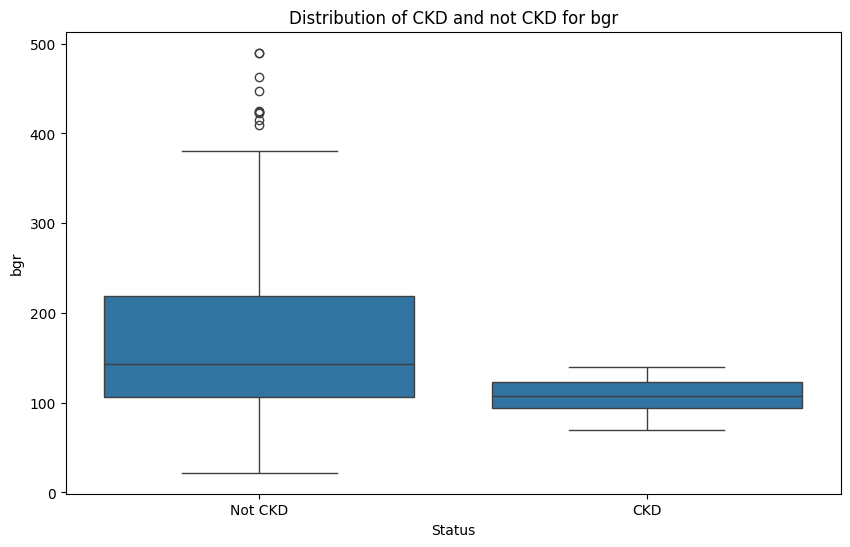

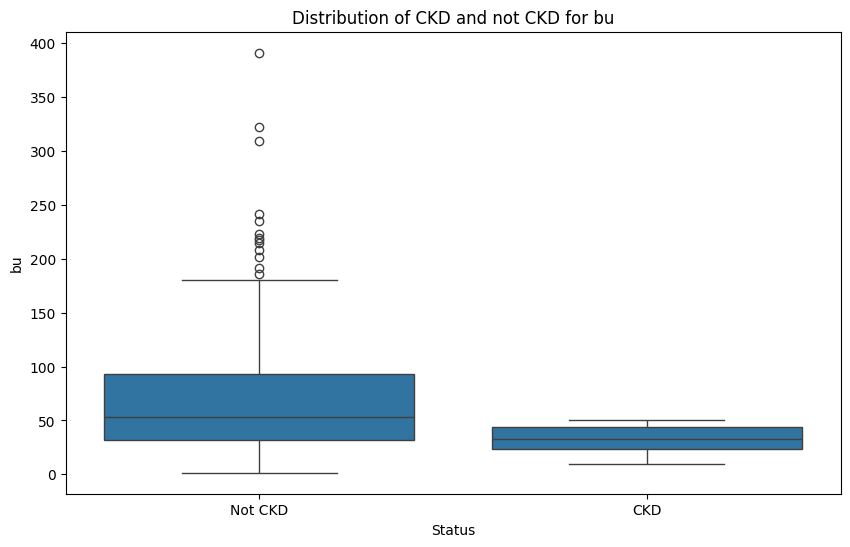

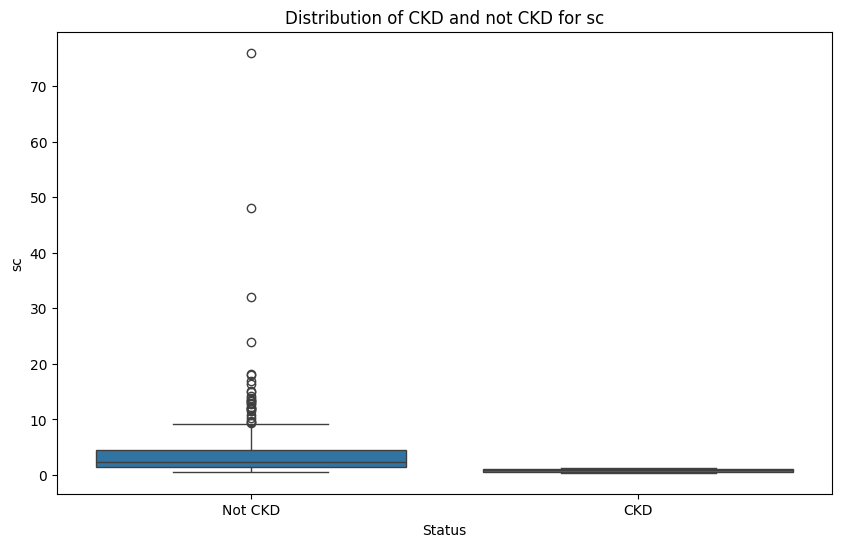

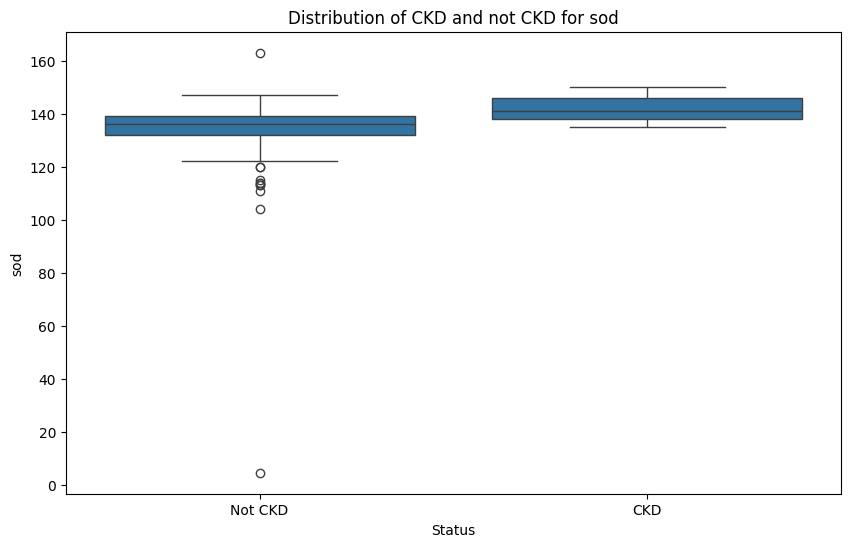

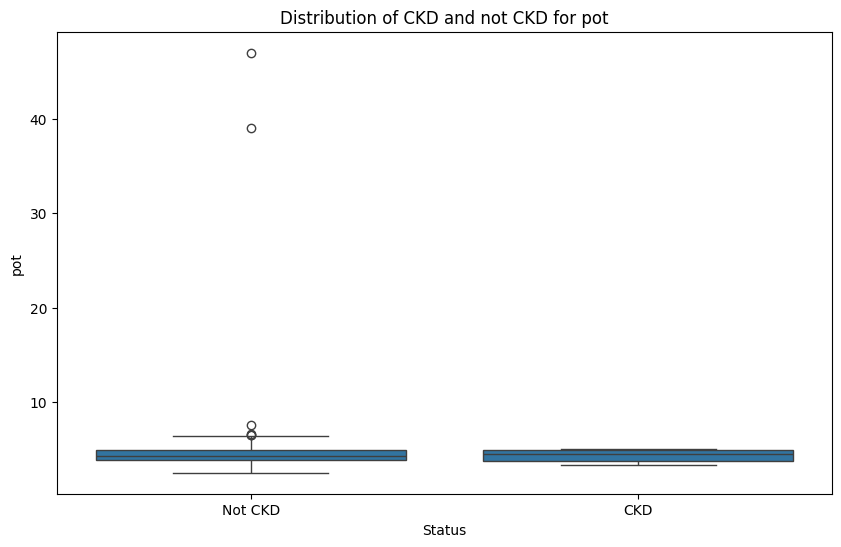

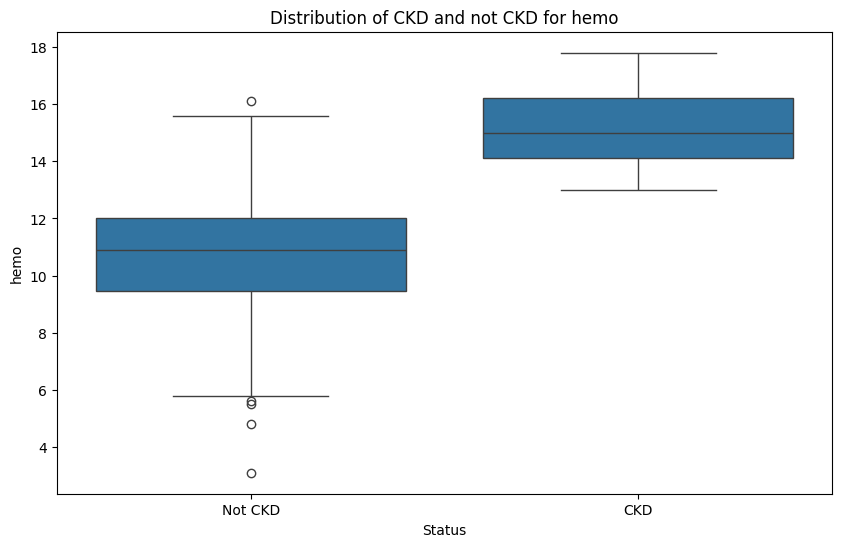

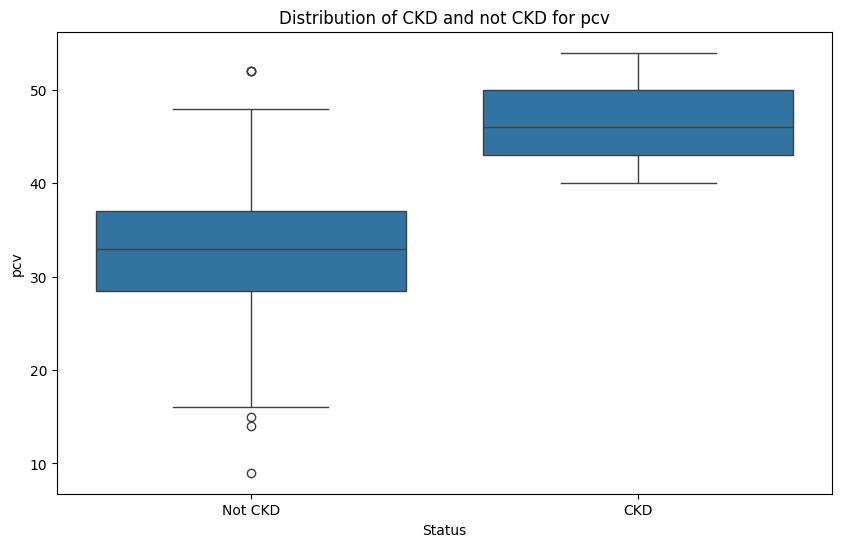

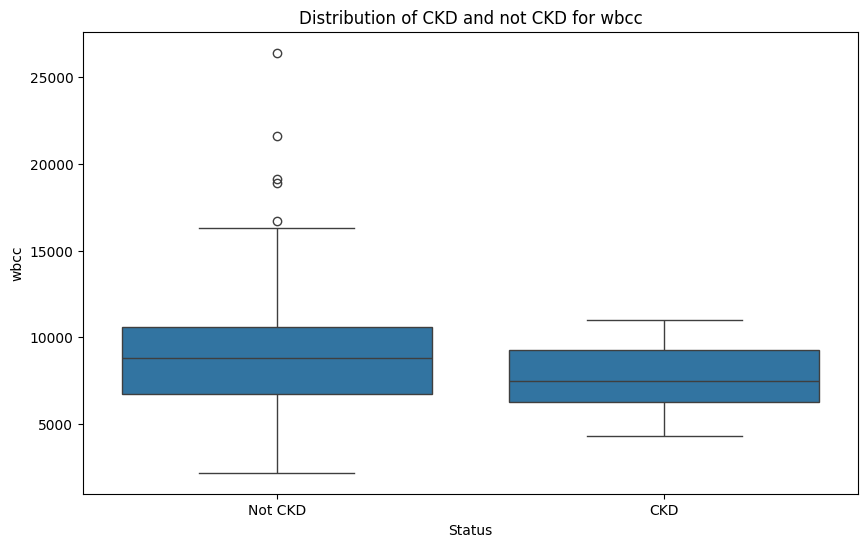

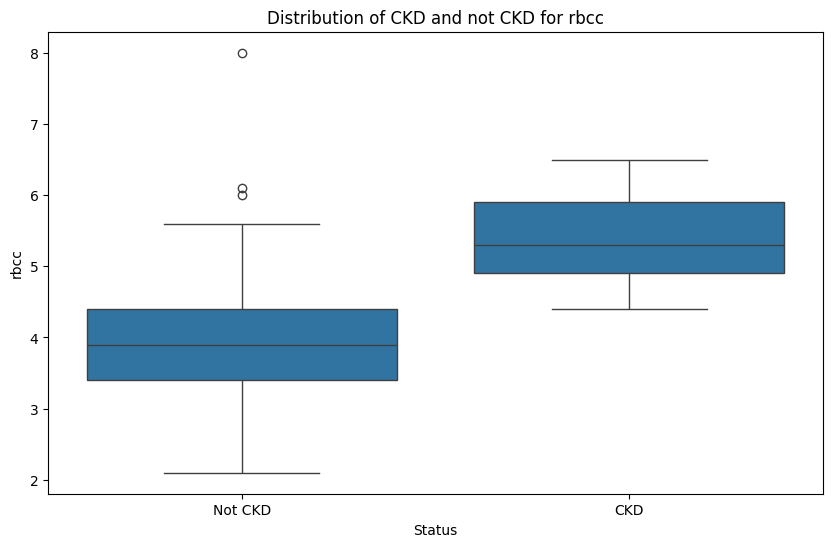

In [2764]:
# analyze the number of observations and variables
print(df.shape)

# analyze the continous variables
print(df[num_col].describe())

print("--------")
for col in cat_col:
    print(df[col].value_counts(normalize=False))

# Create a separate bar plot for each nominal variable
for var in cat_col[:-1]:
    sns.countplot(x=var, hue='class', data=df[df[var] != -1])
    plt.title(f'Distribution of CKD and not CKD for {var}')
    plt.xlabel(f'{var}')
    plt.ylabel('Counts')
    plt.legend(['not CKD','CKD'])

    plt.show()

# Create a separate box plot for each continuous variable
for var in num_col:
    plt.figure(figsize=(10, 6))
    
    sns.boxplot(x='class', y=var, data=df)
    
    plt.title(f'Distribution of CKD and not CKD for {var}')
    plt.xlabel('Status')
    plt.ylabel(var)
    plt.xticks([0, 1], ['Not CKD', 'CKD'])

    plt.show()


There are 400 observations and 51 variables(including dummy variables) in the dataset.  

Lookig at the summary table of the continous variables,  
- Observe that the counts are different in each variables and this indicates there are some missing values across variables.
- The statistical features(minimum and maximum) are widely different in each continous variables and this indicates they were measured in different scales (as described in the dataset library), which needs to be scaled for KNN clustering.

Looking at the box plot of Distribution of CKD and not CKD for hemo and pcv, it is clear that the distributions for not CKD and CKD are different. This indicates that the main differences between people with and without CKD are Hemoglobin and Packed Cell Volumn 


## Question 4

<Axes: >

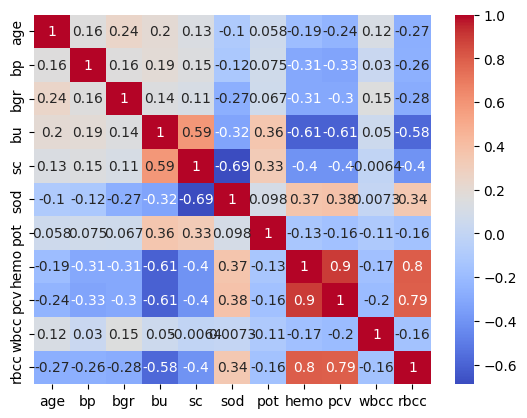

In [2765]:
sns.heatmap(df.drop(cat_col,axis=1).corr(), annot=True,cmap='coolwarm')

- Hemoglobin(`hemo`) and packed cell volume(`pcv`) are highly positively correlated with correlation coefficient of 0.9.
- Red Blood Cells(`rbcc`) and packed cell volume(`pcv`) are highly positively correlated with correlation coefficient of 0.79.
- Red Blood Cells(`rbcc`) and Hemoglobin(`hemo`) are highly positively correlated with correlation coefficient of 0.8.

- This indicates that two of these three variables can be extracted to reduce the dimension without losing significant information since they contain similar information. This also indicates that those with similar Hemoglobin, Packd cell volume, and Red Blood Cells measurements will likely be grouped together in the subgroup analysis (in same cluster)

- Blood Urea(`bu`) is negatively correlated with Hemoglobin(`hemo`), Red Blood Cells(`rbcc`), packed cell volume(`pcv`) with correlation coefficients -0.61, -0.61, -0.58. This indicates Blood Urea(`bu`) can also be extracted to reduce the dimension without losing significant information since they contain similar information, if one of Hemoglobin(`hemo`), Red Blood Cells(`rbcc`), packed cell volume(`pcv`) are included in a model.

- Sodium(`sod`) and Serum Creatinine(`sc`) are negatively correlated with correlation coefficient of -0.69. This indicates one of these two variables can be extracted to reduce the dimension without losing significant information since they contain similar information.

## Question 5

In [2766]:
# impute missing values
imp_num = SimpleImputer(strategy='median')
imp_cat = SimpleImputer(strategy='most_frequent')

df[num_col] = imp_num.fit_transform(df[num_col])
df[cat_col] = imp_cat.fit_transform(df[cat_col])

# convert to coded categorical type variable
for col in cat_col:
    df[col]=pd.Categorical(df[col]).codes

## Question 6

Outlier analysis will not be addressed as  
- from the distribution visualization, there are not many outliers.  
- the outlier can represent extreme but valuable observations that are important for the analysis. In the medical dataset, outliers may represent clinically significant cases.  
- the decision tree model which will furthuer be implemented is robust to outliers, so addressing outliers might not significantly improve the model's performance.  

## Question 7

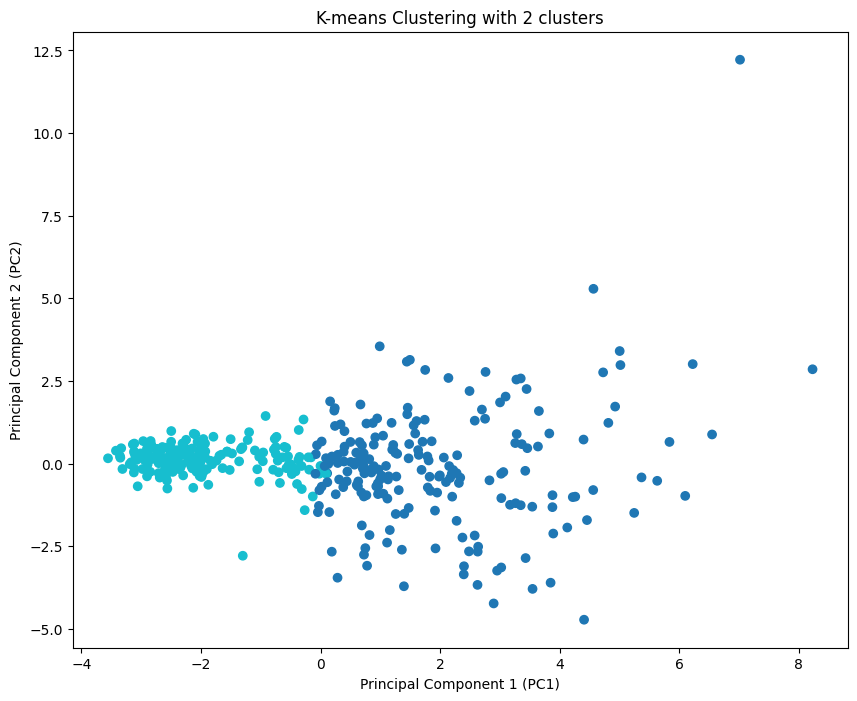

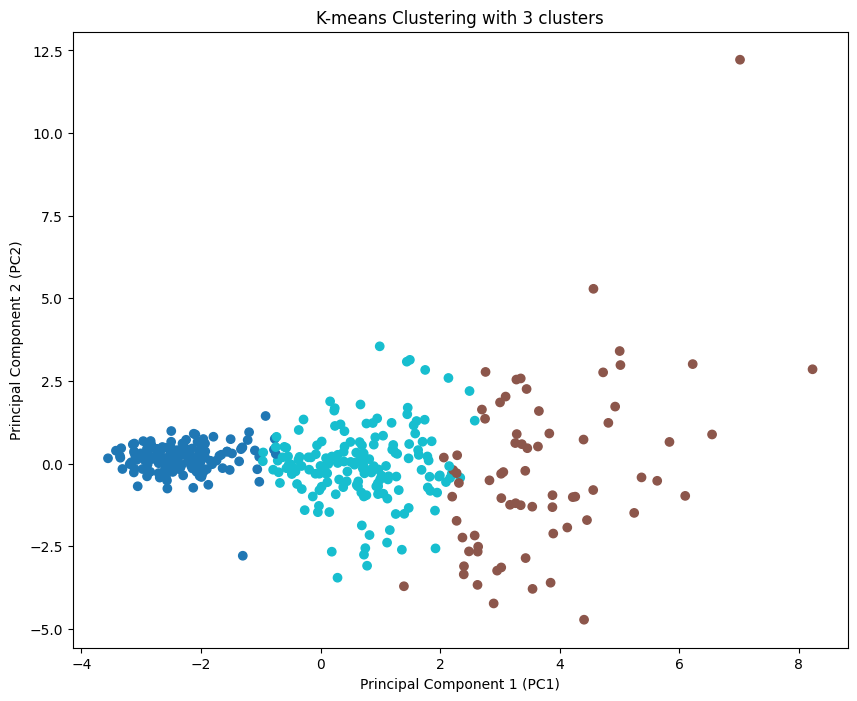

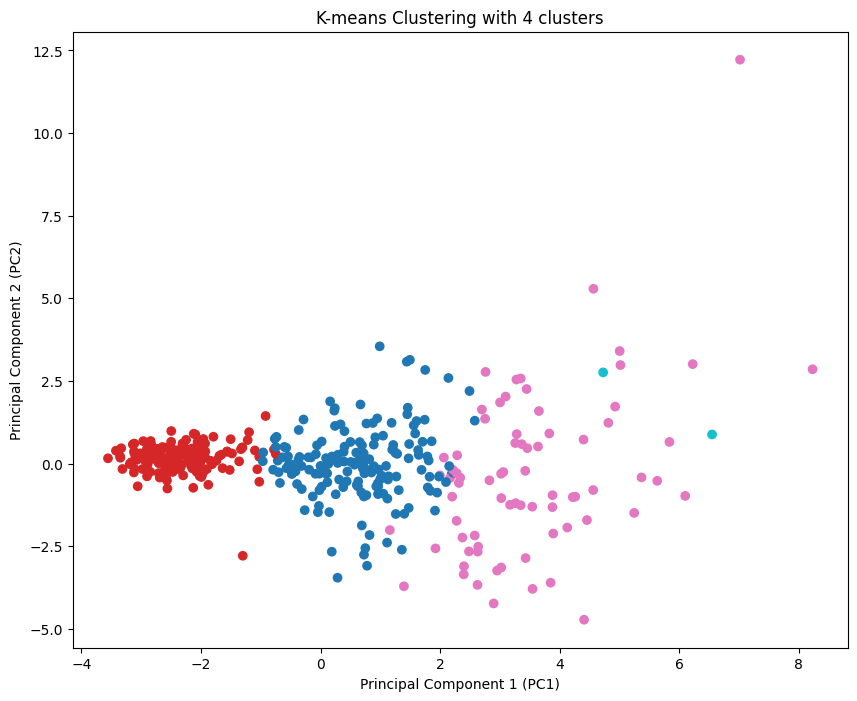

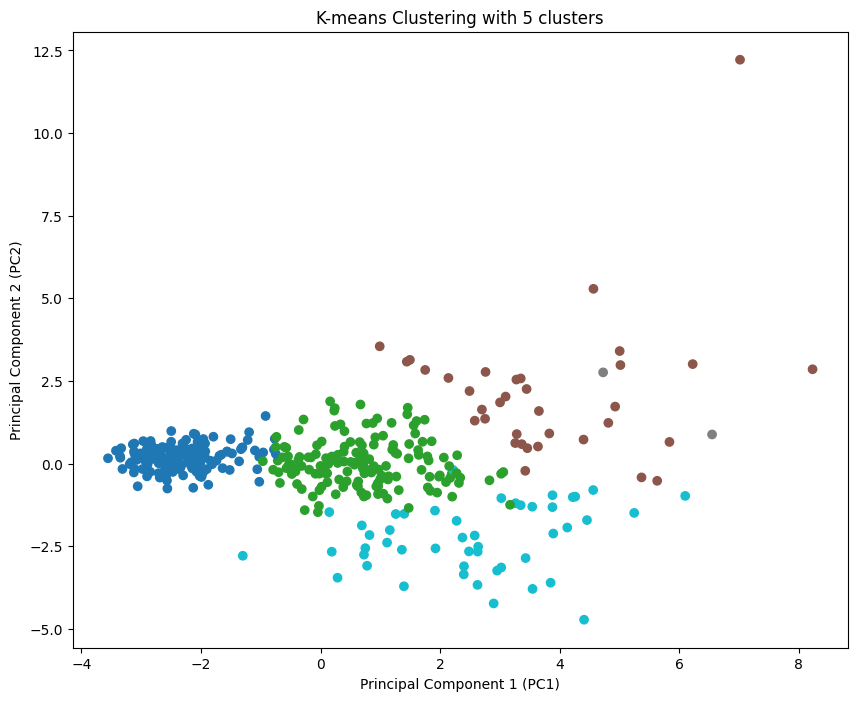

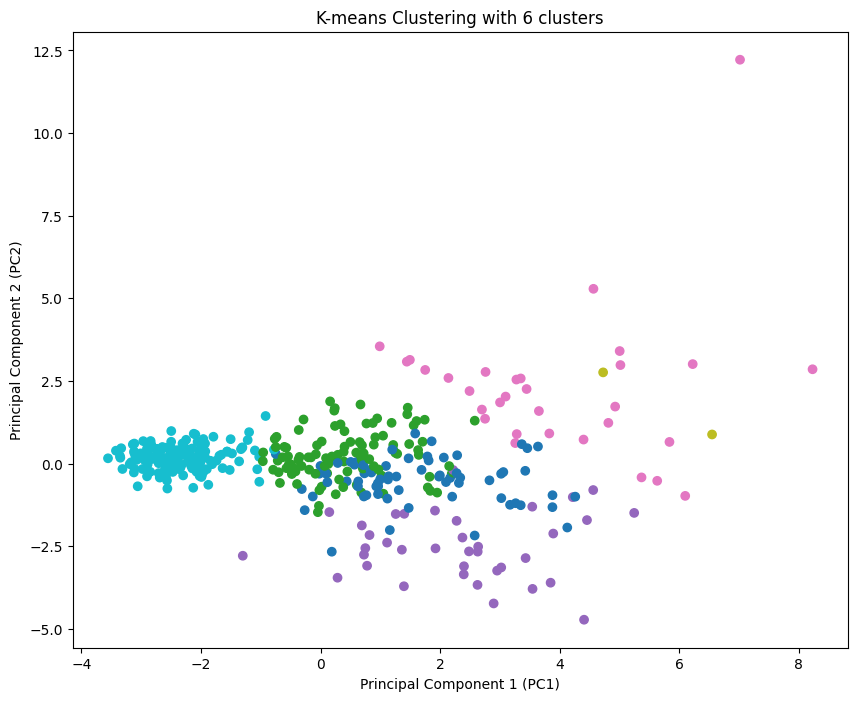

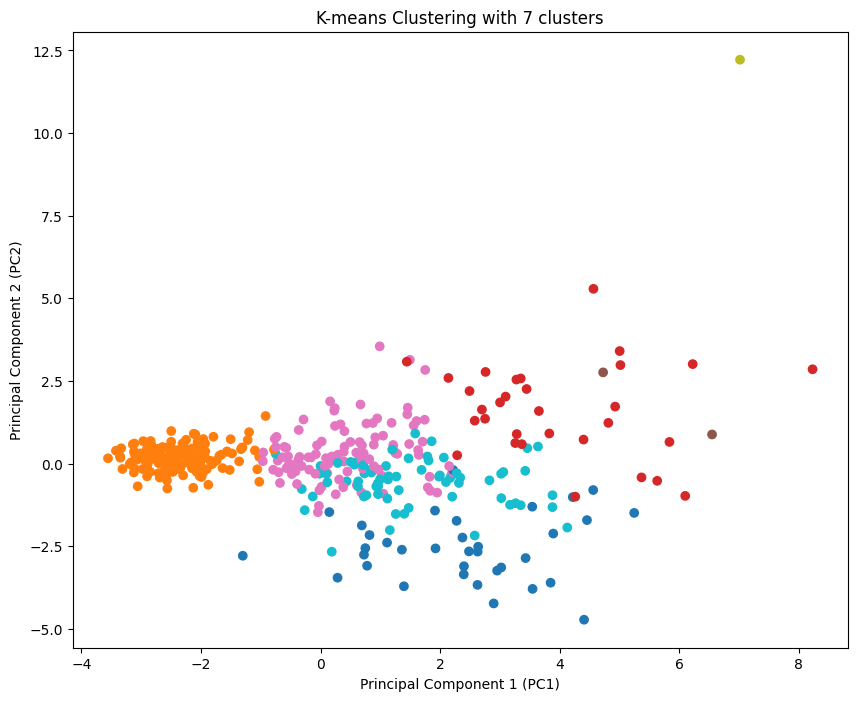

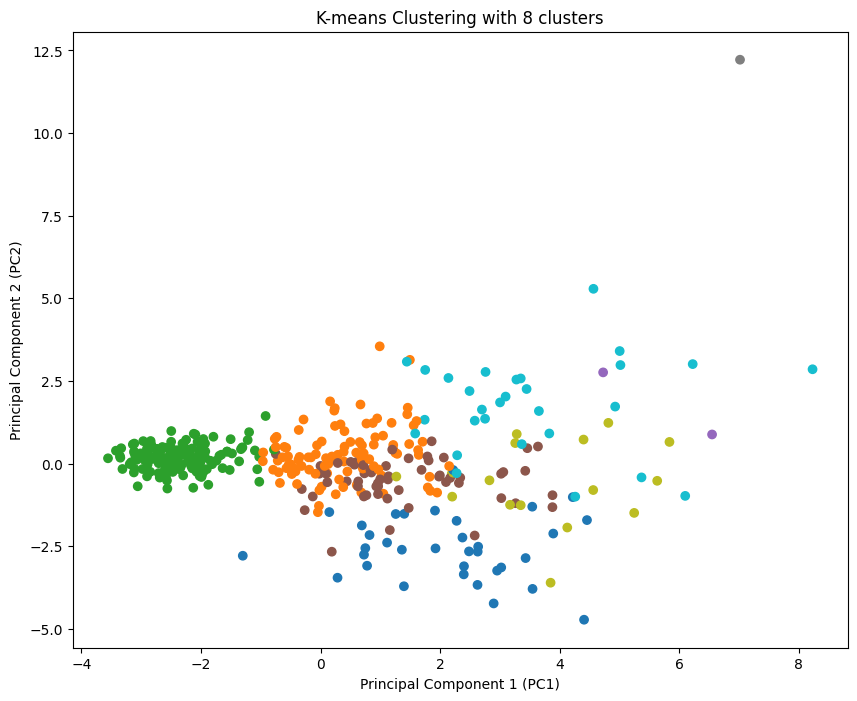

In [2767]:
scaler = StandardScaler()
df[num_col] = scaler.fit_transform(df[num_col])

k_values = [2, 3, 4, 5, 6, 7, 8]

for k in k_values:
    # KMeans clustering
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    km.fit(df)

    # PCA
    pca_ckd = PCA(n_components=2)
    df_plot = pd.DataFrame(pca_ckd.fit_transform(df), columns=['PC1', 'PC2'])

    # Plot the PCA-transformed features
    plt.figure(figsize=(10, 8))
    plt.scatter(df_plot['PC1'], df_plot['PC2'], c=km.labels_, cmap=plt.cm.tab10)
    
    plt.title(f'K-means Clustering with {k} clusters')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    
    plt.show()


Choose K=3, there are 3 subgroups

## Question 8

In [2768]:
# creat dummy variables for categorical variables except 'class'
dummy_col = ['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
df=pd.get_dummies(df,columns=dummy_col)

# predictor variables
X = df.drop('class', axis=1)

# response variable
y = df['class']

# split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=1, stratify=y)


## Question 9

- Model1: KNN model with only numerical features.
- Model2: Decision tree model with only numerical features.
- Model3: Decision tree model with both numerical and categorical features.

- KNN is an intuitive algorithm that does not make any assumption about the underlying distribution in data and can capture the non-linear relationship. However, only numerical features can be included in KNN model.

- Decision tree is interpretable as it can provide decision rules and visualization. Both numerical and categorical variables can be included in Decision tree model.

- Model1 and Model2 will be compared to test which classifier performs better with only numerical features.
- Model2 and Model3 will be compared to test if the model performs better with categorical features included.

## Question 10

- Confusion matrix accuracy score: this measures a ratio of correctly predicted observations to the total observations. High accuracy indicates that the classifer correctly labels high proportion of observations. However, the score can be misleading if the response distribution is not balanced.

- AUC score: this is the area under ROC courve, which plots true positve rate against the false positive rate at different threshold and this compares the true positive rate (sensitivity) and false positive rate (1-specificity) across different thresholds. This is useful when the response distribution is not balanced.

## Question 11

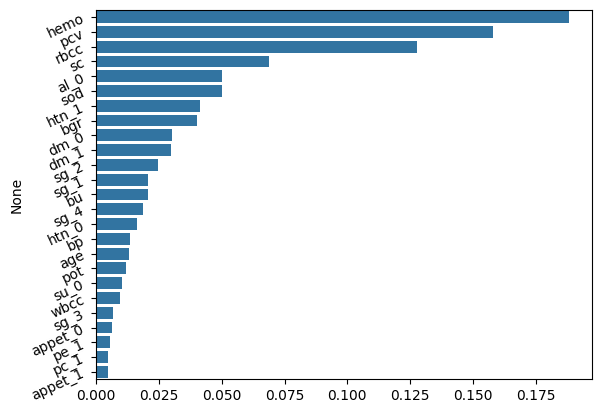

In [2769]:
# use random forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
fea_imp = rf.feature_importances_

sorted_indices = fea_imp.argsort()[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = fea_imp[sorted_indices]

# Plot only the top 25 features
sns.barplot(x=sorted_importances[:25], y=sorted_feature_names[:25])
plt.yticks(rotation=25) 
plt.show()

In [2770]:
# choose top 25 important variables
X = X[sorted_feature_names[:25]]
X_train = X_train[sorted_feature_names[:25]]
X_test = X_test[sorted_feature_names[:25]]

## Question 12 (comment)

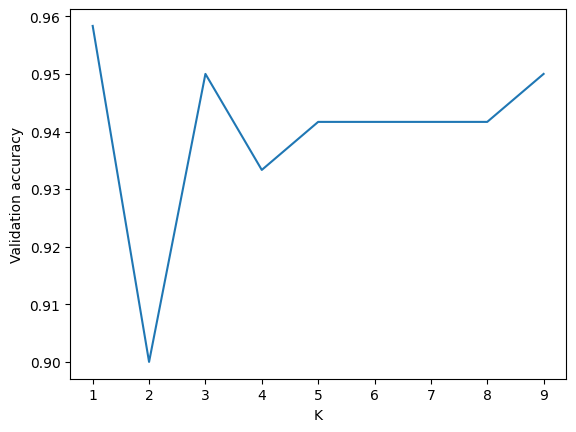

In [2771]:
# KNN 
# choose numerical variables for KNN
col = X.select_dtypes(include=['float64']).columns
X_train_num = X_train[col]
X_test_num = X_test[col]

# Choose the optimal number of k for KNN clustering model
k_range = range(1, 10)
scores = []
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_num, y_train)
    y_pred = knn.predict(X_test_num)
    scores.append(round(metrics.accuracy_score(y_test, y_pred),5))

plt.plot(k_range, scores)
plt.xlabel('K')
plt.ylabel('Validation accuracy')
plt.xticks(range(1,10))
plt.show()

The optimal number of K is 3. K=3 is used in a model.

In [2772]:
# KNN Clustering Model
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_num, y_train)
pred_knn = knn.predict(X_test_num)

conf_knn = metrics.confusion_matrix(y_test, pred_knn).T
accuracy_score_knn = round(metrics.accuracy_score(y_test, pred_knn),4)
auc_score_knn = round(roc_auc_score(y_test, pred_knn),4)

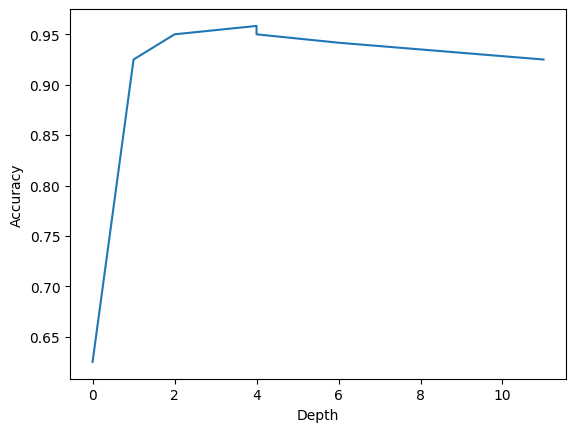

In [2773]:
# Decision Tree Model with only numerical variable from top 25 features
ckd_dt = DecisionTreeClassifier(
    max_depth = 10, 
    random_state=0
) 
path = ckd_dt.cost_complexity_pruning_path(X_train_num,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = [] # save fitted trees with different alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha
        )
    clf.fit(X_train_num, y_train)
    clfs.append(clf)

depth = [clf.tree_.max_depth for clf in clfs]
test_score = [clf.score(X_test_num, y_test) for clf in clfs]

plt.plot(depth, test_score)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Test accuracy is maximum at 4

In [2774]:
ckd_dt_best = DecisionTreeClassifier(
    max_depth = 4, 
    random_state=10
)
ckd_dt_best.fit(X_train_num, y_train)
pred_dt = ckd_dt_best.predict(X_test_num)

conf_dt = metrics.confusion_matrix(y_test, pred_dt).T
accuracy_score_dt = round(metrics.accuracy_score(y_test, pred_dt),4)
auc_score_dt = round(roc_auc_score(y_test, pred_dt),4)

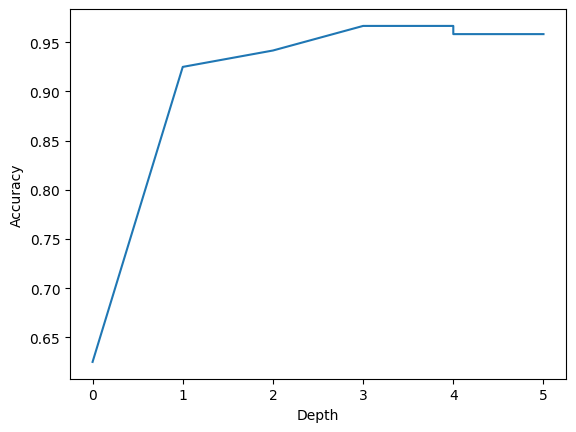

In [2775]:
# Decision Tree Model wiht numerical and categorical variables
# from top 25 features
ckd_dt2 = DecisionTreeClassifier(
    max_depth = 10, 
    random_state=0
) 
path = ckd_dt2.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = [] # save fitted trees with different alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha
        )
    clf.fit(X_train, y_train)
    clfs.append(clf)

depth = [clf.tree_.max_depth for clf in clfs]
test_score = [clf.score(X_test, y_test) for clf in clfs]

plt.plot(depth, test_score)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Test accuracy is maximum at depth 4.

In [2776]:
ckd_dt_best2 = DecisionTreeClassifier(
    max_depth = 4, 
    random_state=10
)
ckd_dt_best2.fit(X_train, y_train)
pred_dt = ckd_dt_best2.predict(X_test)

conf_dt2 = metrics.confusion_matrix(y_test, pred_dt).T
accuracy_score_dt2 = round(metrics.accuracy_score(y_test, pred_dt),4)
auc_score_dt2 = round(roc_auc_score(y_test, pred_dt),4)

In [2777]:
print("KNN Model with Numerical Features (Model1) Results:")
print(f"Confusion Matrix:\n{conf_knn}")
print(f"Accuracy Score: {accuracy_score_knn}")
print(f"AUC Score: {auc_score_knn}")
print("-----------------------------------------------------------------------------")
print("Decision Tree Model with Numerical Features (Model2) Results:")
print(f"Confusion Matrix:\n{conf_dt}")
print(f"Accuracy Score: {accuracy_score_dt}")
print(f"AUC Score: {auc_score_dt}")
print("-----------------------------------------------------------------------------")
print("Decision Tree Model with Numerical and Categorical Features (Model3) Results:")
print(f"Confusion Matrix:\n{conf_dt2}")
print(f"Accuracy Score: {accuracy_score_dt2}")
print(f"AUC Score: {auc_score_dt2}")

KNN Model with Numerical Features (Model1) Results:
Confusion Matrix:
[[72  3]
 [ 3 42]]
Accuracy Score: 0.95
AUC Score: 0.9467
-----------------------------------------------------------------------------
Decision Tree Model with Numerical Features (Model2) Results:
Confusion Matrix:
[[72  3]
 [ 3 42]]
Accuracy Score: 0.95
AUC Score: 0.9467
-----------------------------------------------------------------------------
Decision Tree Model with Numerical and Categorical Features (Model3) Results:
Confusion Matrix:
[[73  3]
 [ 2 42]]
Accuracy Score: 0.9583
AUC Score: 0.9533


- In KNN model(model1), only numerical variables are included from top 25 important variables.
- In first Decision tree model(model2),only numerical variables are included from top 25 important variables.
- In second Decision tree model(model3), all top 25 important variables are included.

- Comparing model1 and model2, there is no difference in the accuracy score and AUC score, the performance of two classifier(KNN and Decision tree) are same when only numerical variables are included as features.

- Compare model2 and model3, model3 has higher accuracy score and AUC score. This indicates the Decision tree model with both numerical and categorical variables included performs better than the Decision tree model with only numerical variables indluced. Hence, the including categorical variables can improve the model's performance and some of the categorical varialbes are important for classification of not CKD and CKD.

- Overall, the Decision Tree model with numerical and categorical features (model3) performs the best among three model. Therefore, it is best to use the Decision Tree model with numerical and categorical features for classification (KNN with categorical and numerical variables cannot be used since KNN only takes numerical features in python). 

## Question 13

[Text(0.6166666666666667, 0.9, 'hemo <= 0.187\ngini = 0.469\nsamples = 400\nvalue = [250, 150]\nclass = No'),
 Text(0.43333333333333335, 0.7, 'rbcc <= 0.431\ngini = 0.073\nsamples = 238\nvalue = [229, 9]\nclass = No'),
 Text(0.26666666666666666, 0.5, 'bu <= -0.835\ngini = 0.034\nsamples = 232\nvalue = [228, 4]\nclass = No'),
 Text(0.13333333333333333, 0.3, 'pcv <= -0.01\ngini = 0.48\nsamples = 5\nvalue = [3, 2]\nclass = No'),
 Text(0.06666666666666667, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = No'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Yes'),
 Text(0.4, 0.3, 'pcv <= 0.297\ngini = 0.017\nsamples = 227\nvalue = [225, 2]\nclass = No'),
 Text(0.3333333333333333, 0.1, 'gini = 0.009\nsamples = 222\nvalue = [221, 1]\nclass = No'),
 Text(0.4666666666666667, 0.1, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]\nclass = No'),
 Text(0.6, 0.5, 'bp <= 0.996\ngini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = Yes'),
 Text(0.5333333333333333, 0.3, 'gini = 0.0\nsamp

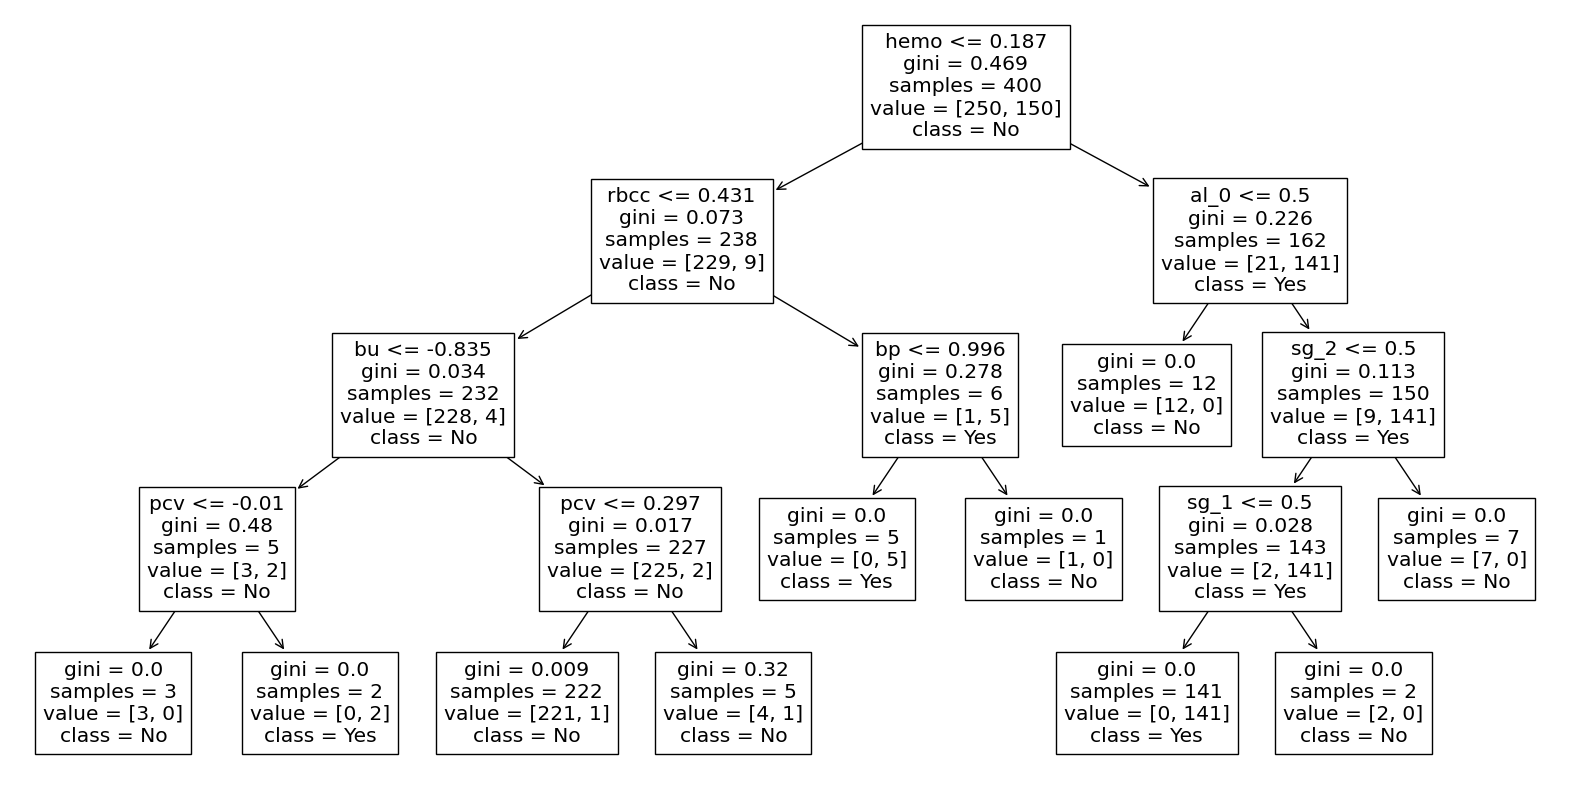

In [2778]:
# fit decision tree model with all observations
ckd_dt_best.fit(X[sorted_feature_names[:25]], y)

plt.figure(figsize=(20, 10))
plot_tree(
    ckd_dt_best, 
    max_depth= 10, 
    feature_names = X.columns.tolist(), 
    class_names=['No', 'Yes']
)

- Hemoglobin(`hemo`): The decision tree fist splits based on the hemoglobin measurements with a threshold of 0.187(scaled) and this indicates that hemoglobin measurement is a primary factor in the classification decision. This suggests that hemoglobin is a key predictor variable and has high influcne on the model's decision path. In the medical context, hemoglobin is a important component of red blood cells and its levels can indicate various medical conditions.

- Blood Urea(`bu`): This is another significant split based on `bu` variable with a threshold of -0.835(scaled), resulting in a subset with very low Gini impurity. This suggests that blood urea measurements are highly informative for classification of not CKD or CKD where hemoglobin measurements are above the initial threshold(0.187) and red blood cell measurements are above threshold of 0.431(scaled). In medical context, blood urea levels can be indicative of kindy function. 

## Question 14

In [2779]:
# find subgroup labels
km = KMeans(n_clusters=3, n_init=20, random_state=0)
km.fit(df)

# append label to each observations in dataframe
df['label']= km.labels_
df['label']=pd.Categorical(df['label']).codes

# seperate X_train, y_train, X_test, y_test into 3 subgroups
# and fit 3 different decision tree models for each subgroups
X_train_sub1 = X_train.loc[df['label'] == 0]
y_train_sub1 = y_train.loc[X_train_sub1.index]
X_test_sub1 = X_test.loc[df['label'] == 0]
y_test_sub1 = y_test.loc[X_test_sub1.index]

dt_sub1 = DecisionTreeClassifier(random_state=1)
dt_sub1.fit(X_train_sub1, y_train_sub1)
y_pred1 = dt_sub1.predict(X_test_sub1)


X_train_sub2 = X_train.loc[df['label'] == 1]
y_train_sub2 = y_train.loc[X_train_sub2.index]
X_test_sub2 = X_test.loc[df['label'] == 1]
y_test_sub2 = y_test.loc[X_test_sub2.index]

dt_sub2 = DecisionTreeClassifier(random_state=1)
dt_sub2.fit(X_train_sub2, y_train_sub2)
y_pred2 = dt_sub2.predict(X_test_sub2)

X_train_sub3 = X_train.loc[df['label'] == 2]
y_train_sub3 = y_train.loc[X_train_sub3.index]
X_test_sub3 = X_test.loc[df['label'] == 2]
y_test_sub3 = y_test.loc[X_test_sub3.index]

dt_sub3 = DecisionTreeClassifier(random_state=1)
dt_sub3.fit(X_train_sub3, y_train_sub3)
y_pred3 = dt_sub3.predict(X_test_sub3)

# combine the results
y_test_comb = pd.concat([y_test_sub1, y_test_sub2, y_test_sub3])
y_pred_comb = pd.Series(
    np.concatenate([y_pred1, y_pred2, y_pred3]),
    index=y_test_comb.index
)

y_test_comb_sorted = y_test_comb.sort_index()
y_pred_comb_sorted = y_pred_comb.sort_index()

conf_sub = metrics.confusion_matrix(y_test_comb_sorted, y_pred_comb_sorted).T
accuracy_score_sub = round(metrics.accuracy_score(y_test_comb_sorted, y_pred_comb_sorted),4)
auc_score_sub = round(roc_auc_score(y_test_comb_sorted, y_pred_comb_sorted),4)

print("Decision Model Results:")
print(f"Confusion Matrix:\n{conf_sub}")
print(f"Accuracy Score: {accuracy_score_sub}")
print(f"AUC Score: {auc_score_sub}")

Decision Model Results:
Confusion Matrix:
[[75  2]
 [ 0 43]]
Accuracy Score: 0.9833
AUC Score: 0.9778


- The train and test sets are seperated into 3 subgroups, labeled as 0,1,3, which are found from the subgroup analysis in question 7. The Decision tree models are fitted in each subgroups and made predictions, resulting in three predictions overall. Then, the predicted results are combined and compared with the test sets. 

- This model predicted all observations except for 2. The accuracy score is 0.9833 and the AUC score is 0.9778, which are higher than the performance of the models discussed in question 12, indicating the improvement in model's performance.

- From the comparison, it is clear that fitting different models for each subgropus will result in higher accruacy in prediction.


## Question 15

- Jihwan Kim(400182249): single member, did all of the work

## Question 16